# Applications of Transfer Learning to Synthetic Image Detection

This notebook tests the applicability of transfer learning to the problem of detecting synthetic images such as those generated by Stable Diffusion. It uses the CIFAKE dataset, which combines fake 32x32 images produced by StableDiffusion 1.4 with real images from the CIFAR-10 dataset.

The CIFAKE dataset is used to fine-tune the ResNet18 and VGG11 models, which are used as binary classifiers (real or fake).
The performance of the fine-tuned models is then evaluated again the test set. We also test the generalizability of the learned features for the task of synthetic image detection by measuring the performance of the fine-tuned models against a smaller dataset containing a collection of real and synthetic images belonging to classes outside of the CIFAR-10 dataset. These images are taken from the CIFAR-100 dataset and StableDiffusion 1.4 respectively.

The transferability of learned features to the task of identifying synthetic images generated by different diffusion models is also tested by testing the models against a small dataset containing in-domain images generated by DALL-E 2. 

The CIFAR-10 classes included in the training data are: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck.

The CIFAR-100 classes used for out-domain testing are: trees, people, household furniture, and large natural outdoor scenes.

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy



cudnn.benchmark = True
plt.ion()

### Data processing

In [2]:
# Data augmentation and normalization 
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# load data
data_dir = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images'

train_data = datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train'])
test_data = datasets.ImageFolder(os.path.join(data_dir, 'test'), data_transforms['test'])
outdomain_test_data = datasets.ImageFolder(os.path.join('/kaggle/input/cifake-outdomain-test', 'test'), data_transforms['test'])
outmodel_test_data = datasets.ImageFolder(os.path.join('/kaggle/input/cifake-outmodel-test', 'test'), data_transforms['test'])


# split off validation set
n_train = int(len(train_data) * 0.9)
n_valid = len(train_data) - n_train
class_names = train_data.classes

train_data, valid_data = torch.utils.data.random_split(train_data, [n_train, n_valid])

valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = data_transforms['train']

print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')
print(f'Number of outdomain testing examples: {len(outdomain_test_data)}')
print(f'Number of outmodel testing examples: {len(outmodel_test_data)}')


dataloaders = {}

dataloaders['train'] = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2)
dataloaders['valid'] = torch.utils.data.DataLoader(valid_data, batch_size=32, shuffle=True, num_workers=2)
dataloaders['test'] = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True, num_workers=2)
dataloaders['test_outdomain'] = torch.utils.data.DataLoader(outdomain_test_data, batch_size=32, shuffle=True, num_workers=2)
dataloaders['test_outmodel'] = torch.utils.data.DataLoader(outmodel_test_data, batch_size=32, shuffle=True, num_workers=2)

dataset_sizes = {
    'train': len(train_data),
    'valid': len(valid_data),
    'test': len(test_data),
    'test_outdomain': len(outdomain_test_data),
    'test_outmodel': len(outmodel_test_data)
}


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Number of training examples: 90000
Number of validation examples: 10000
Number of testing examples: 20000
Number of outdomain testing examples: 198
Number of outmodel testing examples: 140


Display a subset of the training data:

In [3]:
def normalize_image(image):
    img_min = image.min()
    img_max = image.max()
    image.clamp_(min = img_min, max = img_max)
    image.add_(-img_min).div_(img_max - img_min + 1e-5)
    return image    

In [4]:
def plot_images(images, labels, classes, normalize = True):

    cols = int(np.sqrt(len(images)))
    rows = int(np.sqrt(len(images)))
    
    fig = plt.figure(figsize = (15, 15))

    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        image = images[i]
        if normalize:
            image = normalize_image(image)
        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        label = classes[labels[i]]
        ax.set_title(label)
        ax.axis('off')

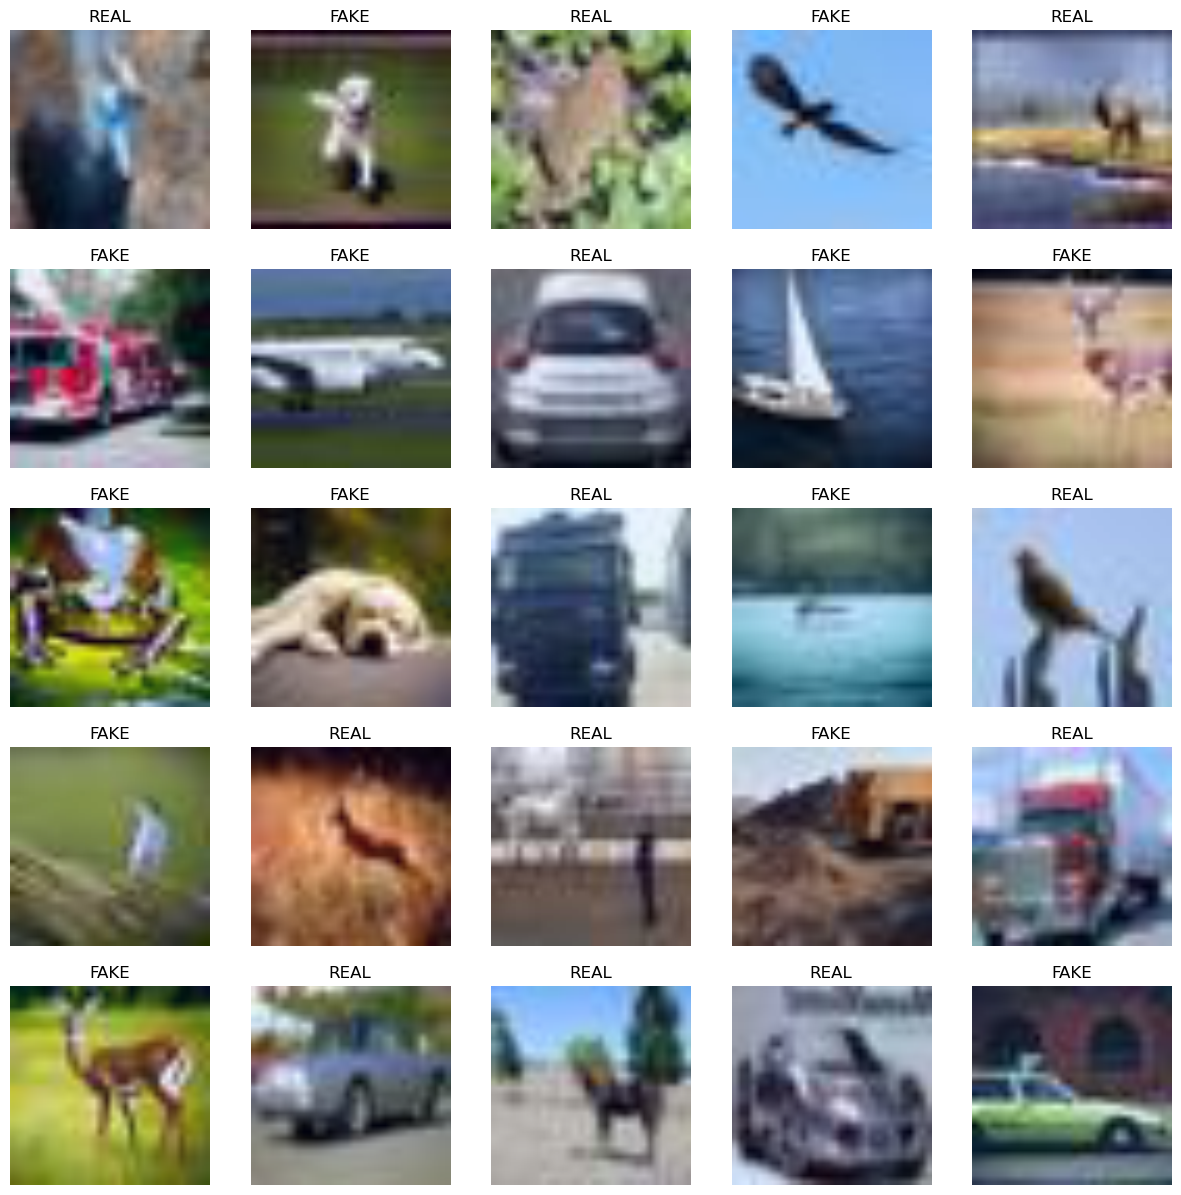

In [5]:
images, labels = zip(*[(image, label) for image, label in 
                           [train_data[i] for i in range(25)]])

classes = test_data.classes

plot_images(images, labels, classes)

### Utility functions

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, model_str="model"):
    start_time = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_accuracy = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Accuracy: {epoch_acc:.4f}')

            if phase == 'valid' and epoch_acc > best_accuracy:
                best_accuracy = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), f'{model_str}.pt')

        print()

    time_elapsed = time.time() - start_time
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best validation accuracy: {best_accuracy:4f}')

    model.load_state_dict(best_model_wts)
    return model

### Model definition and training

Initialize a Resnet18 model with pre-trained weights, replace the fully-connected layer to obtain two outputs, and define training parameters

In [7]:
model_resnet = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_resnet.fc.in_features
# Replace the fully connected layer to obtain two ouputs (real/fake)
model_resnet.fc = nn.Linear(num_ftrs, 2)

model_resnet = model_resnet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_resnet = optim.SGD(model_resnet.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_resnet, step_size=5, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Train the model over 5 epochs:

In [ ]:
model_resnet = train_model(model_resnet, criterion, optimizer_resnet, exp_lr_scheduler,
                       num_epochs=5, model_str='model_resnet')

In [8]:
model_vgg = models.vgg11_bn(weights=models.VGG11_BN_Weights.IMAGENET1K_V1)

num_ftrs = model_vgg.classifier[-1].in_features
model_vgg.classifier[-1] = nn.Linear(num_ftrs, 2)

model_vgg = model_vgg.to(device)

optimizer_vgg = optim.SGD(model_vgg.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler_vgg = lr_scheduler.StepLR(optimizer_vgg, step_size=5, gamma=0.1)

Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth


  0%|          | 0.00/507M [00:00<?, ?B/s]

In [ ]:
model_vgg = train_model(model_vgg, criterion, optimizer_vgg, exp_lr_scheduler_convnext,
                       num_epochs=5, model_str='model_vgg')

### Evaluation

In [9]:
model_resnet.load_state_dict(torch.load('model_resnet.pt'))

<All keys matched successfully>

In [10]:
model_vgg.load_state_dict(torch.load('model_vgg.pt'))

<All keys matched successfully>

In [11]:
def get_predictions(model, iterator, get_images=False):

    model.eval()
    
    probs = []
    images = []
    labels = []
    with torch.no_grad():
        for (image, label) in iterator:
            image = image.to(device)
            label_predicted = model(image)
            label_probability = nn.functional.softmax(label_predicted, dim=-1)
            if get_images:
                images.append(image.cpu())
            labels.append(label.cpu())
            probs.append(label_probability.cpu())
            #if test_count > count:
            #    break

    if get_images:
        images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs



In [13]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def plot_confusion_matrix(labels, pred_labels, classes):

    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    cm = ConfusionMatrixDisplay(cm, display_labels=class_names)
    cm.plot(values_format='d', cmap='Blues', ax=ax)
    plt.xticks(rotation=20)
    


In [26]:
def plot_n_most_incorrect(incorrect, classes, n):

    rows = int(np.sqrt(n))
    cols = int(np.sqrt(n))

    fig = plt.figure(figsize = (25, 20))

    for i in range(min(len(incorrect), rows*cols)):
        ax = fig.add_subplot(rows, cols, i+1)
        image, true_label, probs = incorrect[i]
        image = image.permute(1, 2, 0)
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim = 0)
        true_class = classes[true_label]
        incorrect_class = classes[incorrect_label]

        image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true: {true_class} ({true_prob:.3f})\n' \
                     f'pred: {incorrect_class} ({incorrect_prob:.3f})')
        ax.axis('off')
        
    fig.subplots_adjust(hspace=0.2)

In [19]:
def print_results(model, iterator, get_images=False):
    images, labels, probs = get_predictions(model, iterator, get_images)
    pred_labels = torch.argmax(probs, 1)
    plot_confusion_matrix(labels, pred_labels, classes)
    print(f"Accuracy:{accuracy_score(labels,pred_labels)*100:.2f}%")
    print(f"Precision:{precision_score(labels,pred_labels)*100:.2f}%")
    print(f"Recall:{recall_score(labels,pred_labels)*100:.2f}%")
    print(f"F-1 Score:{f1_score(labels,pred_labels)*100:.2f}%")
    
    if get_images:
        corrects = torch.eq(labels, pred_labels)

        incorrect_examples = []

        for image, label, prob, correct in zip(images, labels, probs, corrects):
            if not correct:
                incorrect_examples.append((image, label, prob))

        incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)
        plot_n_most_incorrect(incorrect_examples, classes, 16)


### ResNet Evaluation
#### In-domain

Accuracy:97.73%
Precision:97.27%
Recall:98.22%
F-1 Score:97.74%


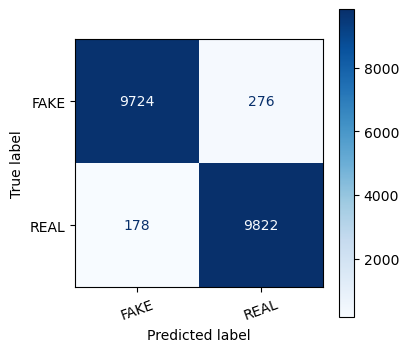

In [16]:
print_results(model_resnet, dataloaders['test'])

#### Out-domain

Accuracy:86.87%
Precision:83.49%
Recall:91.92%
F-1 Score:87.50%


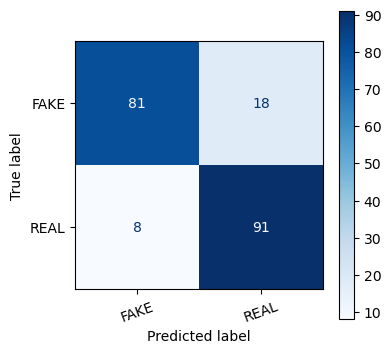

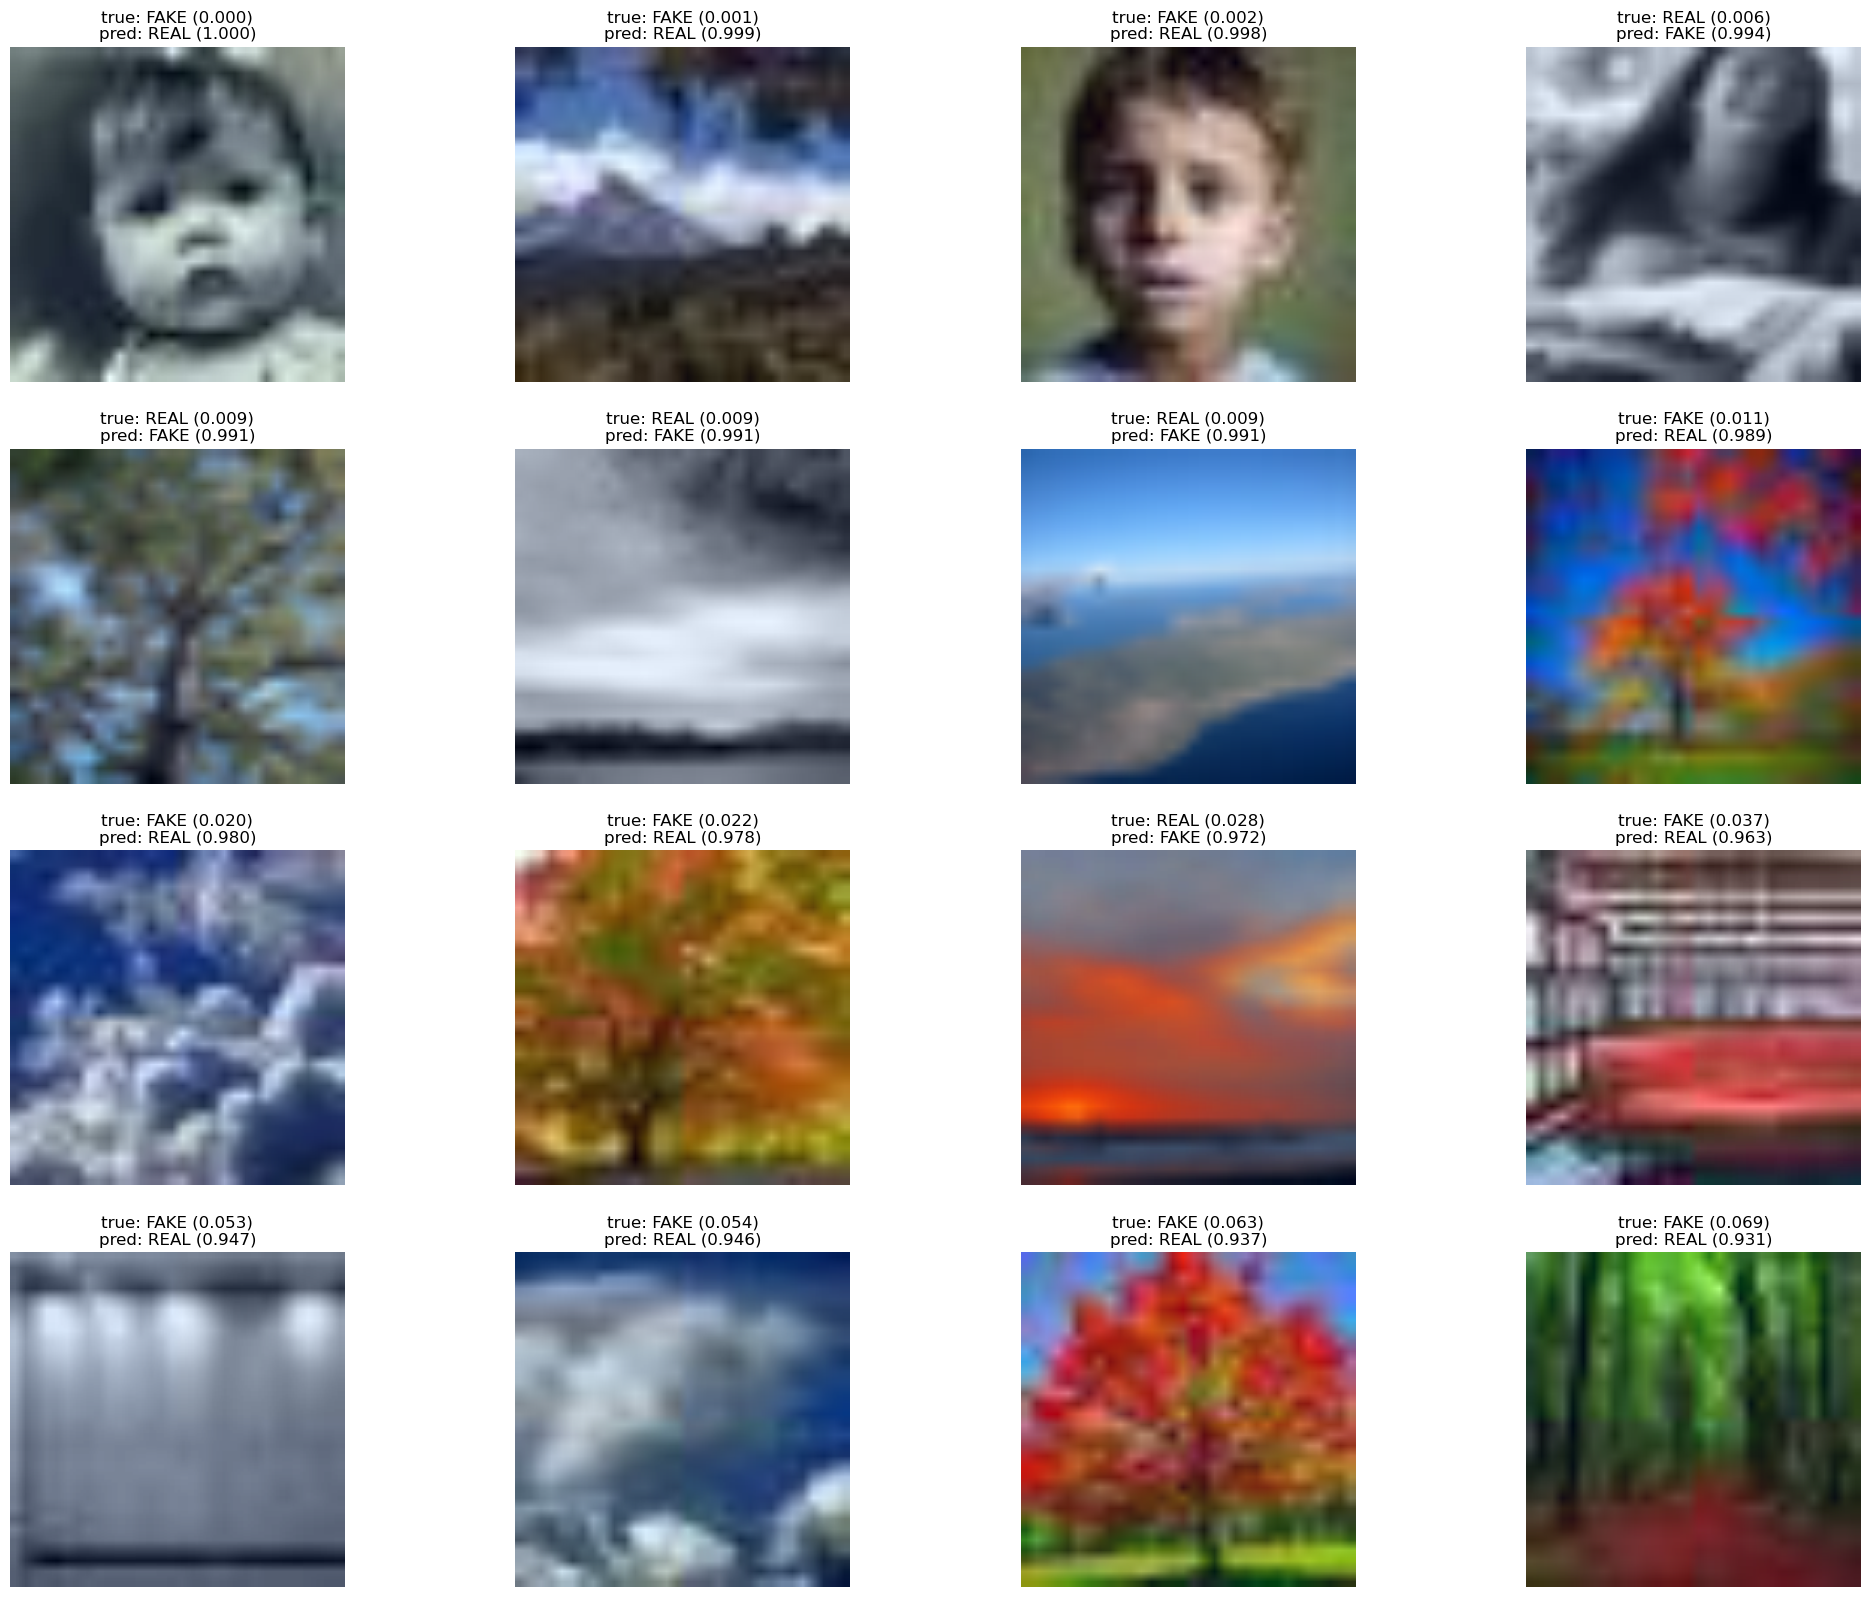

In [20]:
print_results(model_resnet, dataloaders['test_outdomain'], get_images=True)

#### Out-model

Accuracy:67.86%
Precision:60.87%
Recall:100.00%
F-1 Score:75.68%


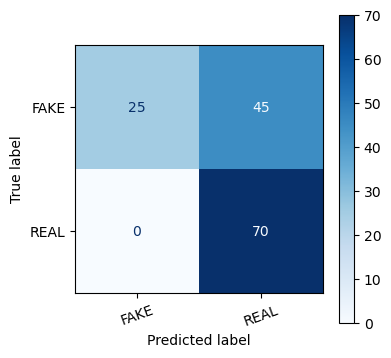

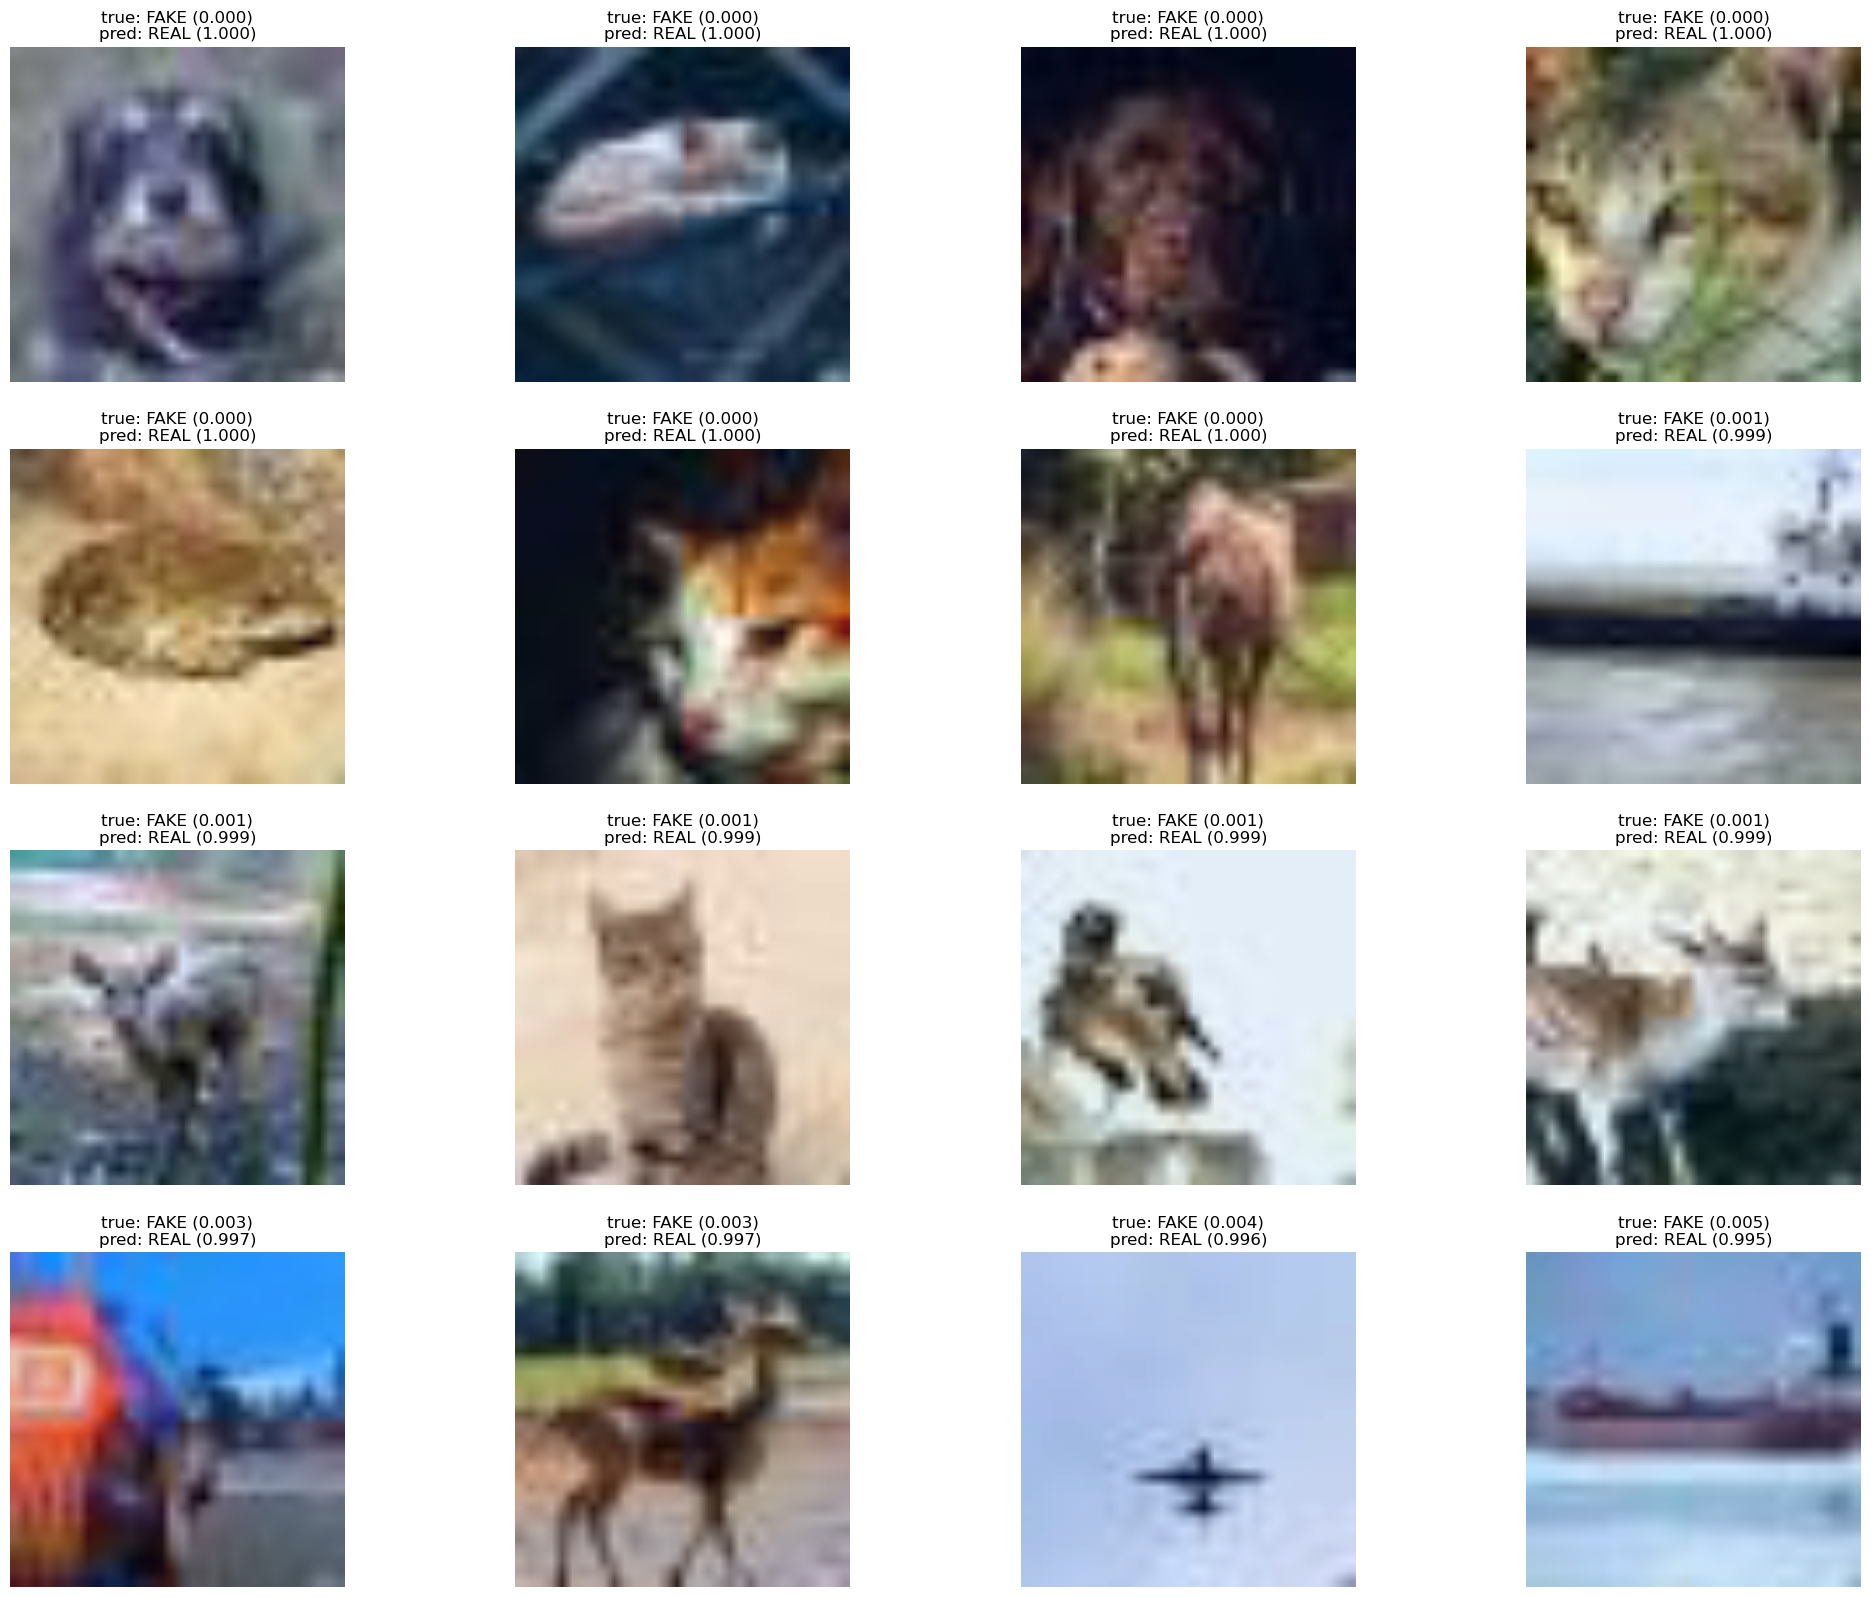

In [21]:
print_results(model_resnet, dataloaders['test_outmodel'], get_images=True)

### VGG results
#### In-domain

Accuracy:97.78%
Precision:98.53%
Recall:97.01%
F-1 Score:97.76%


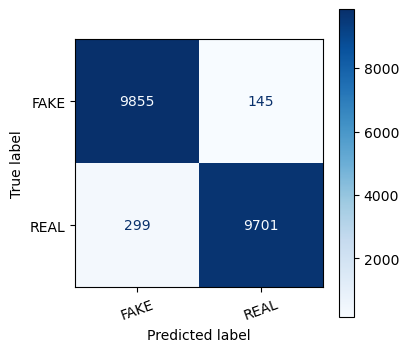

In [22]:
print_results(model_vgg, dataloaders['test'])

#### Out-domain

Accuracy:84.85%
Precision:82.24%
Recall:88.89%
F-1 Score:85.44%


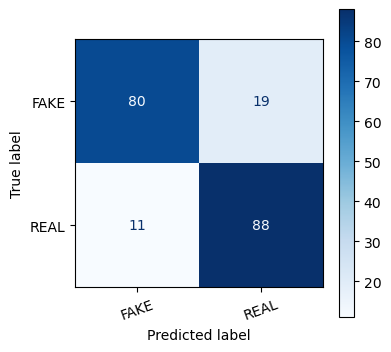

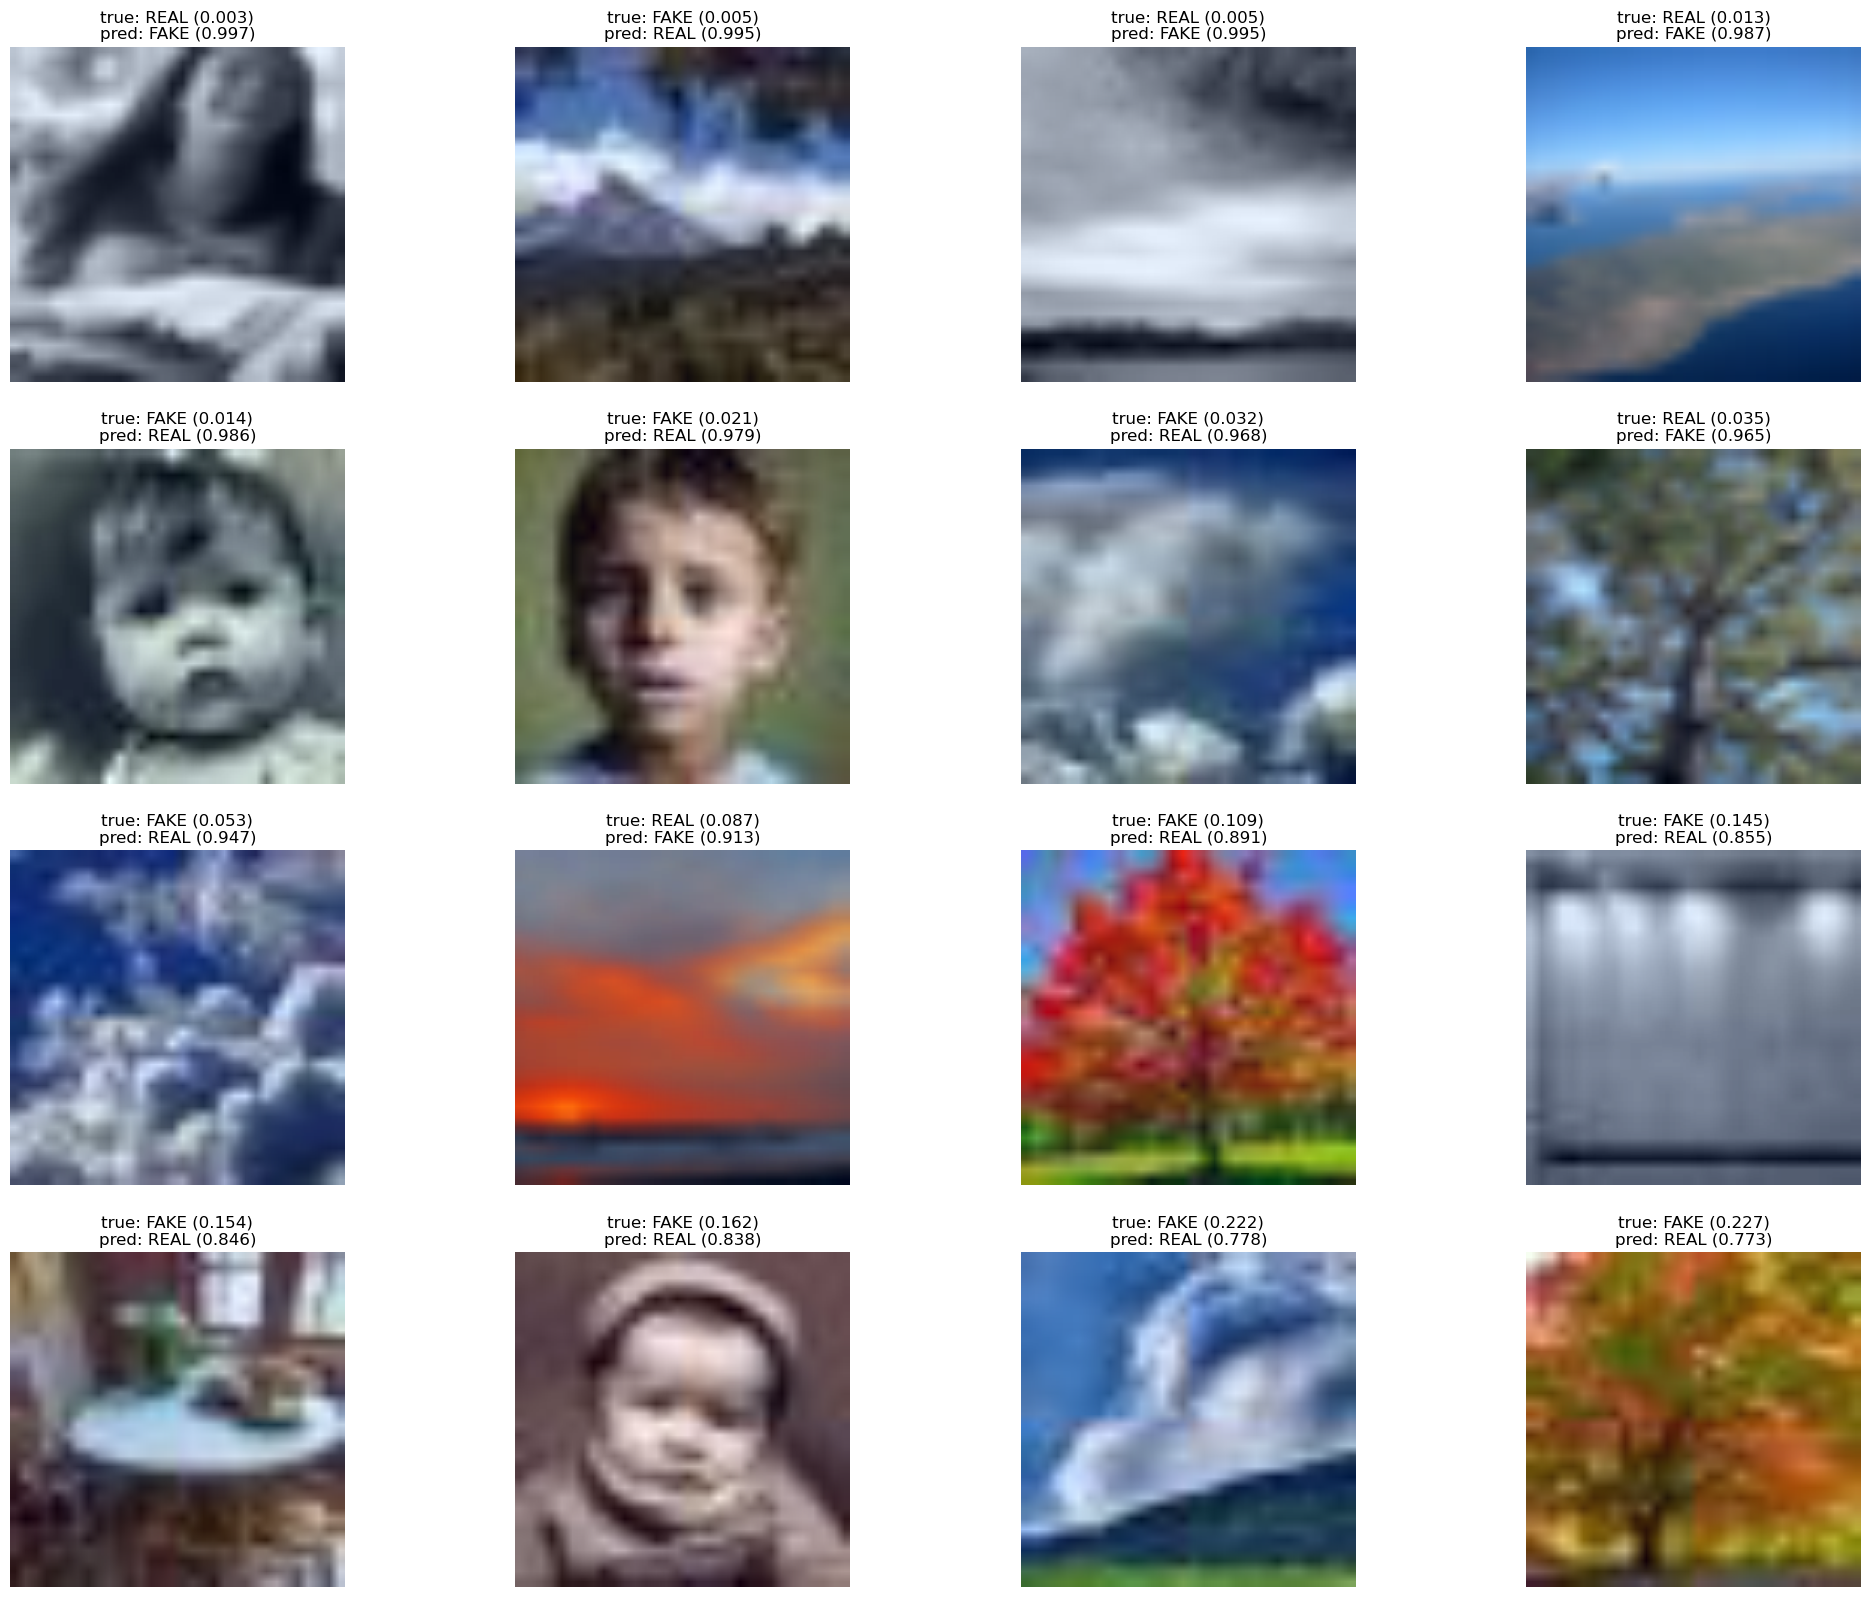

In [23]:
print_results(model_vgg, dataloaders['test_outdomain'], get_images=True)

#### Out-model

Accuracy:69.29%
Precision:62.39%
Recall:97.14%
F-1 Score:75.98%


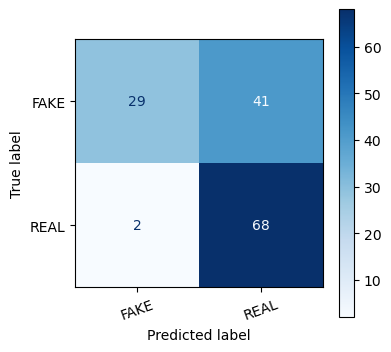

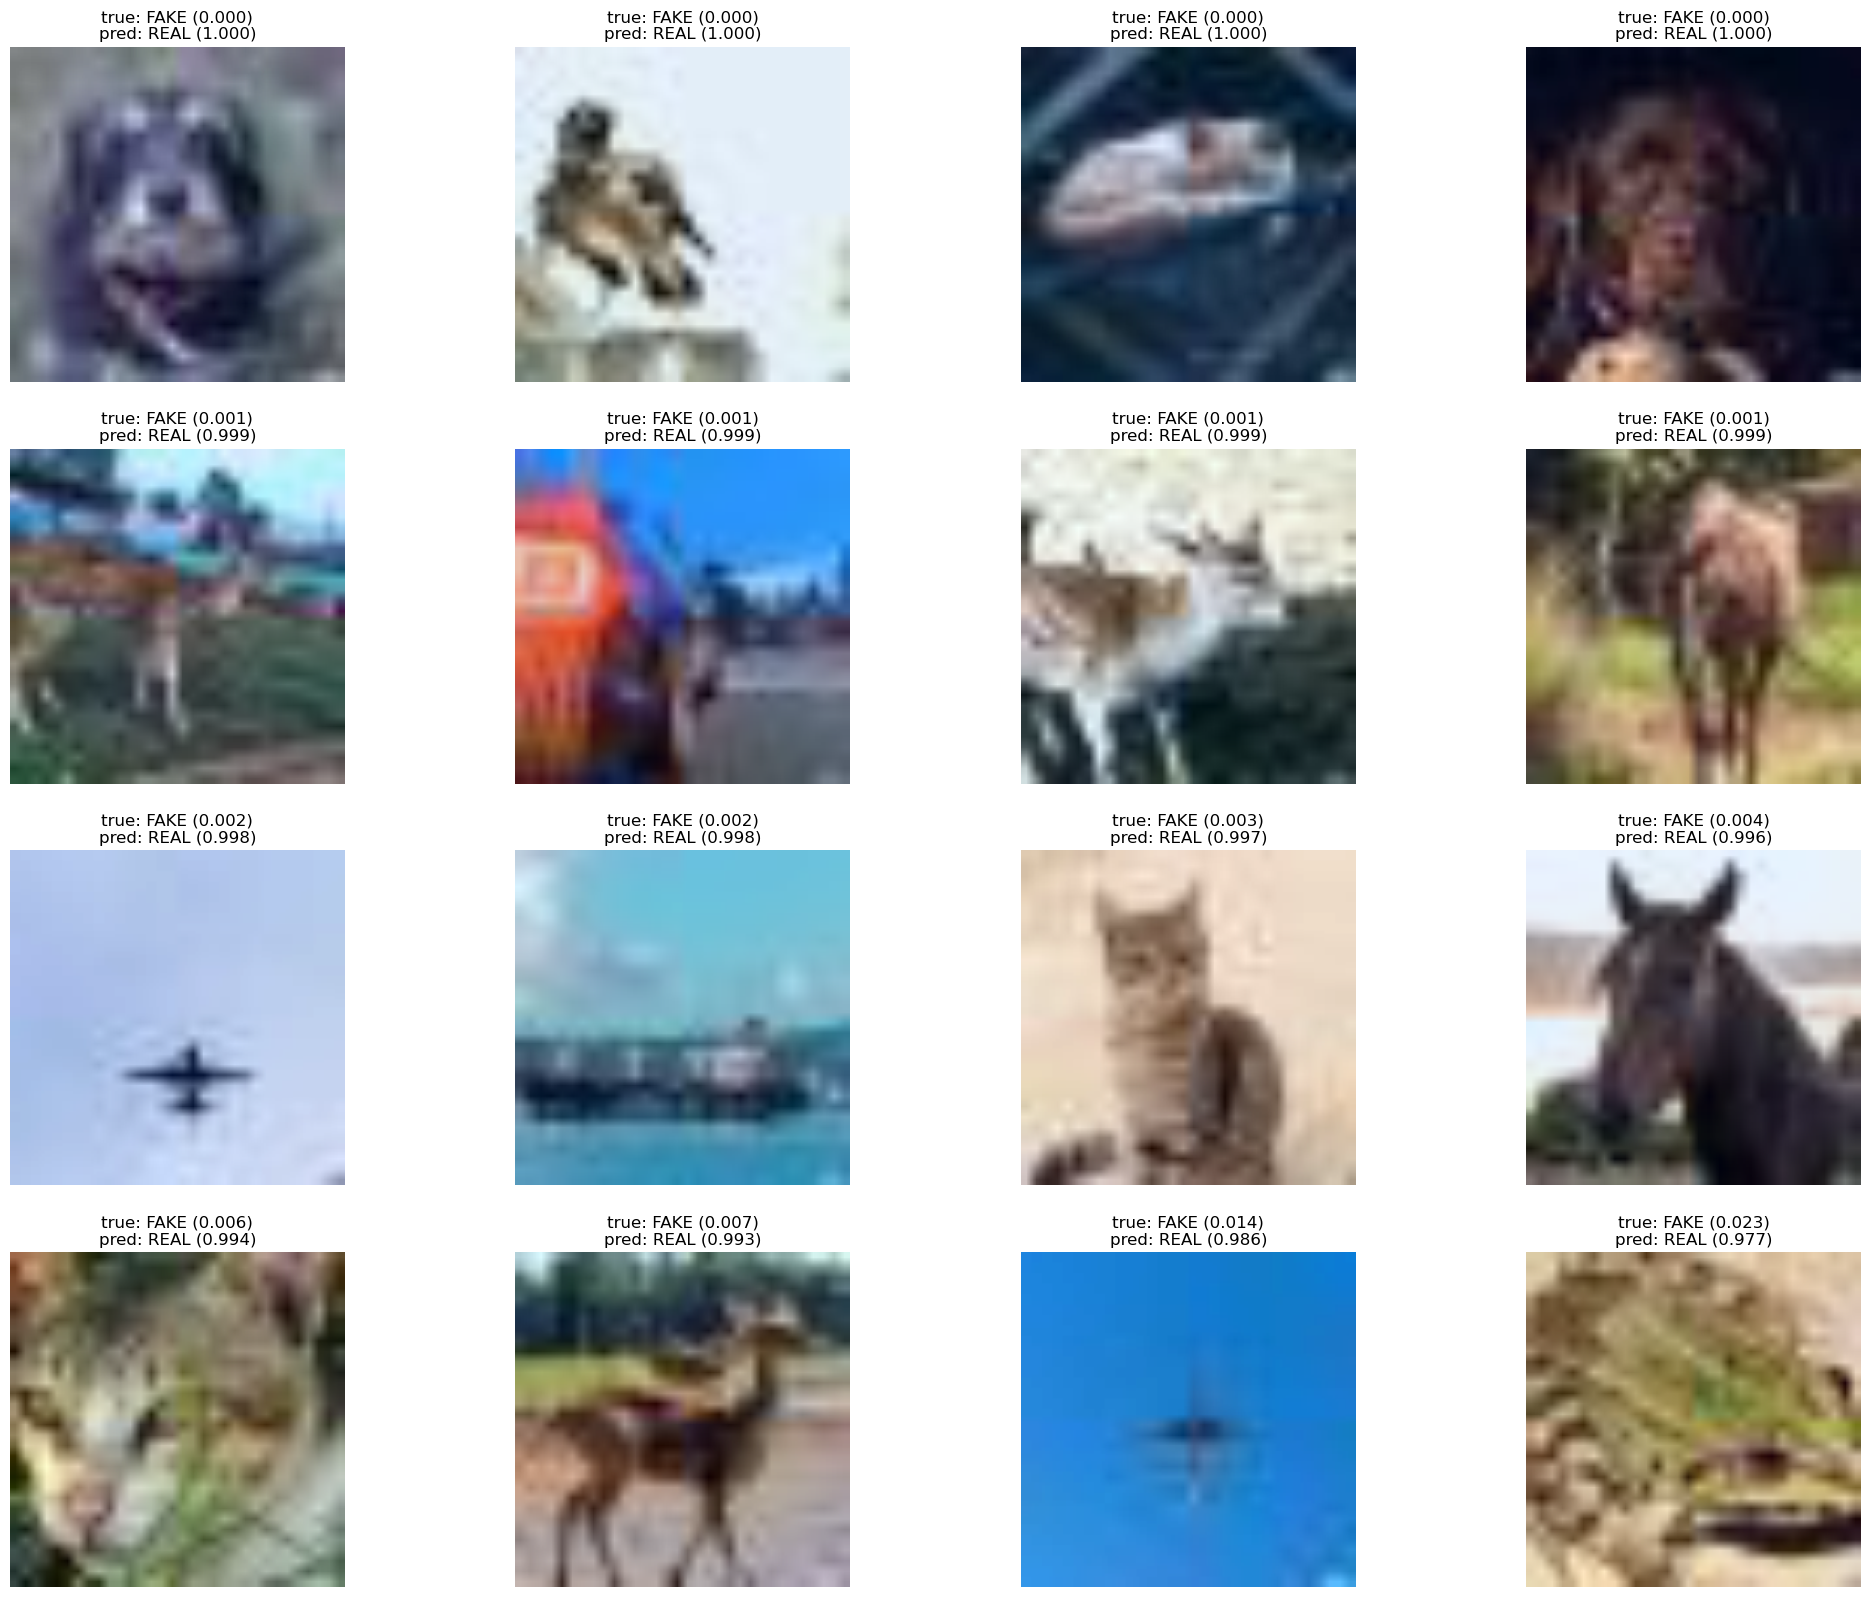

In [27]:
print_results(model_vgg, dataloaders['test_outmodel'], get_images=True)